# Fruit Inspection - Exercise 3

## Importing the needed libraries

In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
print(os.getcwd())

C:\Users\aleda\Documents\GitHub\FruitDefectsInspection\final challenge


## Tools

In [2]:
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

def plot_images_row(imgs, title = ""):

  imgs_dim = [img.shape for img in imgs]
  max_rows = max([img_dim[0] for img_dim in imgs_dim])
  max_cols = max([img_dim[1] for img_dim in imgs_dim])
  
  cropped_imgs = []
  for i in imgs:
   cropped_imgs.append(cv2.copyMakeBorder(i,0, max_rows-i.shape[0], 0, max_cols - i.shape[1],cv2.BORDER_REPLICATE))

  fig = plt.figure(1, (14, 5))
  fig.suptitle(title, fontsize=16)
  grid = ImageGrid(fig, 111, # similar to subplot(111)
                  nrows_ncols = (1, len(imgs)), # creates 2x2 grid of axes
                  axes_pad=0.1, # pad between axes in inch.
                  )

  for i in range(len(imgs)):
      grid[i].imshow(cropped_imgs[i], cmap='gray') # The AxesGrid object work as a list of axes.

  plt.show()


def show_masking_effect(binary_mask, color_image, show_output=False, transparency=0.7):
    background = color_image
    overlay = np.stack([ binary_mask, np.zeros(binary_mask.shape, dtype=np.uint8), np.zeros(binary_mask.shape,np.uint8)], axis=2)
    added_image = cv2.addWeighted(background,0.9,overlay,transparency,0)

    if show_output:
        plt.imshow(added_image, cmap="gray")
        plt.title("Image + binary mask overlay")
        plt.show()
    
    return added_image 

## Importing the images

### Black and white images

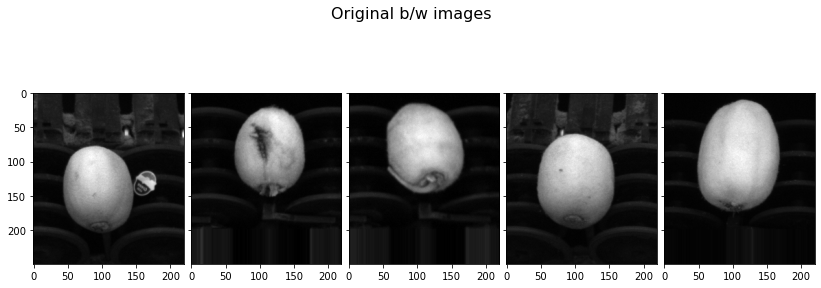

In [3]:
imgs = [cv2.imread(f"./src/C0_00000{i}.png",cv2.IMREAD_GRAYSCALE) for i in range (6,10)]
imgs.append(cv2.imread(f"./src/C0_000010.png",cv2.IMREAD_GRAYSCALE))
plot_images_row(imgs, title = "Original b/w images")

### Color images

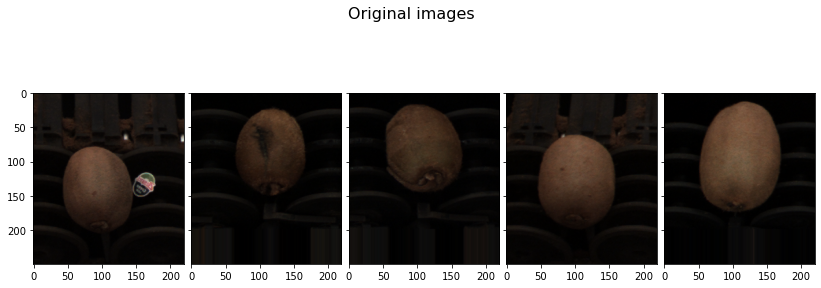

In [4]:
color_imgs = [cv2.imread(f"./src/C1_00000{i}.png") for i in range (6,10)]
color_imgs.append(cv2.imread(f"./src/C1_000010.png"))
color_imgs = [cv2.cvtColor(i,cv2.COLOR_BGR2RGB) for i in color_imgs]
plot_images_row(color_imgs, title = "Original images")

### Checking parallax

Checking if the sizes of b/w images and color images correctly match
[(250, 220), (200, 220), (200, 220), (250, 220), (200, 220)]
[(250, 220, 3), (200, 220, 3), (200, 220, 3), (250, 220, 3), (200, 220, 3)]



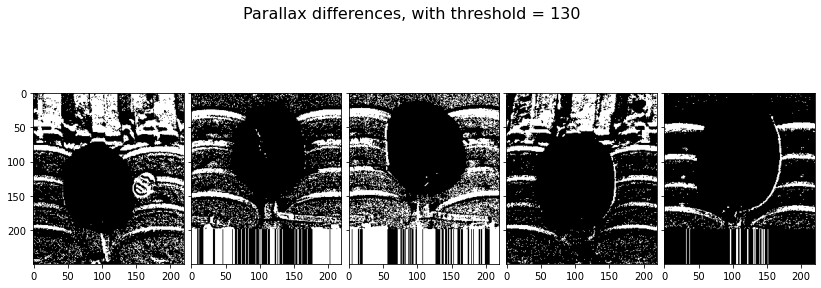

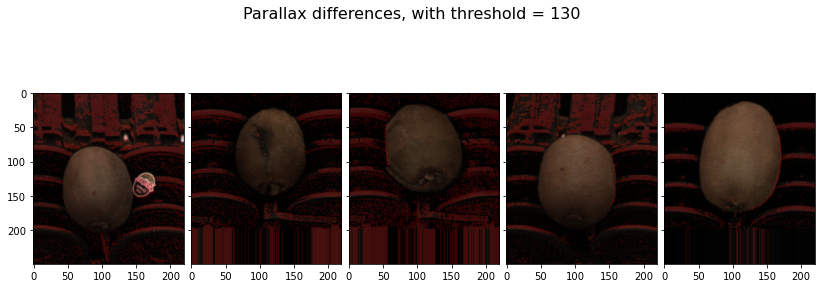

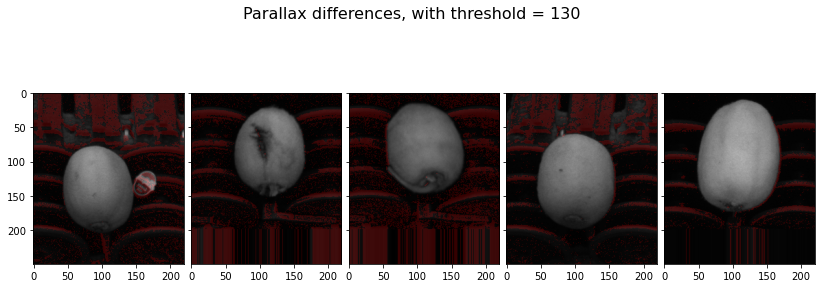

In [5]:
print("Checking if the sizes of b/w images and color images correctly match")
print([i.shape for i in imgs])
print([i.shape for i in color_imgs])
print()

parallax_difference = [np.array(abs(imgs[i] - cv2.cvtColor(color_imgs[i], cv2.COLOR_RGB2GRAY))) for i in range(len(imgs))]
thresh = 130
parallax_mask = [(parallax_difference[i]>thresh).astype(np.uint8)*255 for i in range(len(imgs))]
plot_images_row(parallax_mask, title = f"Parallax differences, with threshold = {thresh}")

overlay_parallax_color = [show_masking_effect(parallax_mask[i], color_imgs[i], transparency=0.2) for i in range(len(imgs))]
overlay_parallax_bw = [show_masking_effect(parallax_mask[i], cv2.cvtColor(imgs[i], cv2.COLOR_GRAY2RGB), transparency=0.2) for i in range(len(imgs))]
plot_images_row(overlay_parallax_color, title = f"Parallax differences, with threshold = {thresh}")
plot_images_row(overlay_parallax_bw, title = f"Parallax differences, with threshold = {thresh}")

We can easily see that there's little parallax (some overlayed zones are caused because of the different conversion from color to gray levels). 

Some minor differences in the final highlighted defects (in the original gray level image with respect to the original color image) is expected, as we can see from the images above.

## Intensity Histograms

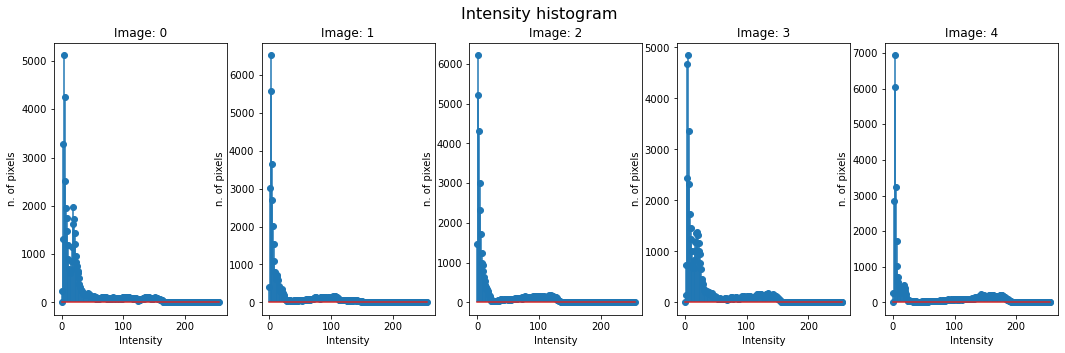

In [6]:
def plot_intensity_hists(hists, fig_size=(18,5),thresh=None):

    fig, axs = plt.subplots(1, len(hists))
    fig.set_size_inches(fig_size[0], fig_size[1])
    fig.suptitle("Intensity histogram", fontsize=16)

    for i in range(len(hists)):
        axs[i].stem(hists[i],use_line_collection=True) # The AxesGrid object work as a list of axes.
        axs[i].set_title(f"Image: {i}")
        if thresh:
          axs[i].axvline(thresh, color='r', label="manual threshold")
          axs[i].legend()
        axs[i].set_xlabel("Intensity")
        axs[i].set_ylabel("n. of pixels")
    plt.show()


hists = [ np.histogram(i.flatten(), 256, [0,256])[0] for i in imgs]
plot_intensity_hists(hists)

The histogram is not really "bimodal": we can see two peaks in the lower values, but they're not easily separable one from the other. A point-operator should be applied in order to ease the segmentation.

## Background/foreground segmentation

In order to detect defects, the detection has to be limited just to the ROI corresponding to the fruit under analysis: binarization is applied to do so.

To perform the binary segmentation of the main fruit we'll use the same technique applied in ex1 and ex2: a custom defined function followed by OTSU's method and the use of morphological operators.

The morph operations applied are:
*   **closing** with a 5x4 ellipse
*   **opening** with a 92x100 ellipse  

This process is performed through the function ```customFunctionOtsuMorphKiwis```

In [7]:
def gammaFunction(r, displacement=0):
    table = [((max(i+displacement,0) / 255) ** r) * 255 for i in range(256)]
    table = np.array(table, np.uint8)
    return table


def sigmoidHillFunction(displacement):
    table = [1/(1+np.e**(-(i-11)))*256 for i in np.linspace(0,10,  displacement + 1)]
    return table


def customFunction(displacement = -28):
    r = 1/8
    table = gammaFunction(r,displacement)
    sigmoid = sigmoidHillFunction(-displacement)
    table = np.array([sigmoid[i] if i<=(-displacement) else table[i] for i in range(len(table))], np.uint8)
    return table


def customFunctionCorrection(img, displacement=-28):
    table = customFunction(displacement)
    return cv2.LUT(img, table)


def customFunctionOtsu(img, displacement=-28):
    filtered_img = customFunctionCorrection(img, displacement)
    th_value,th = cv2.threshold(filtered_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return th


def customFunctionOtsuMorphKiwis(img, displacement, show_output=False):
    '''
    In this implementation, Custom function + OTSU is applied,
    Morph Transformations (closing with a 5x5 circle, opening with a 4x4 square) following it


    img: The image to apply Custom function + OTSU + Morph Transformations (Opening+Closing) on
    show_output: True if the obtained image has to be printed
    '''
    custom_otsu_mask = customFunctionOtsu(img, displacement)
    
    kernel_closing = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,4))
    kernel_opening = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(92,100))

    morphed_mask = cv2.morphologyEx(custom_otsu_mask, cv2.MORPH_CLOSE, kernel_closing)
    morphed_mask = cv2.morphologyEx(morphed_mask, cv2.MORPH_OPEN, kernel_opening)

    if show_output:
        plt.imshow(morphed_mask, cmap="gray")
        plt.title("Custom Function Point Operator + OTSU + Morph")
        plt.show()

    return morphed_mask

#### Graph of the custom function

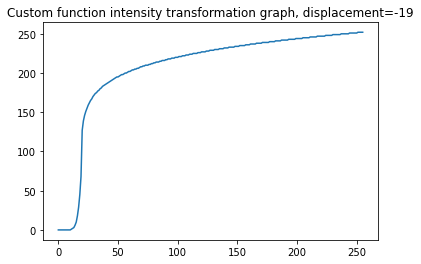

In [8]:
displacement = -19
plt.plot(customFunction(displacement=displacement))
plt.title(f"Custom function intensity transformation graph, displacement={displacement}")
plt.show()

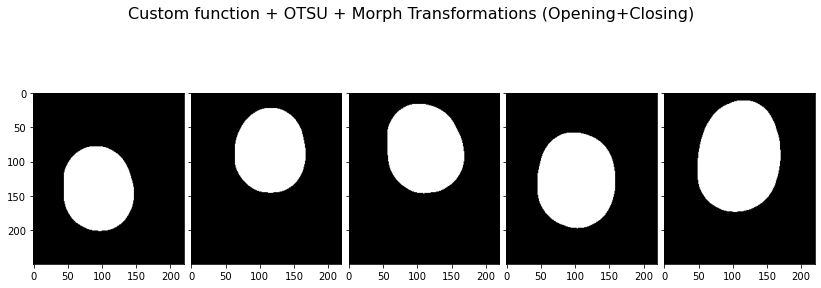

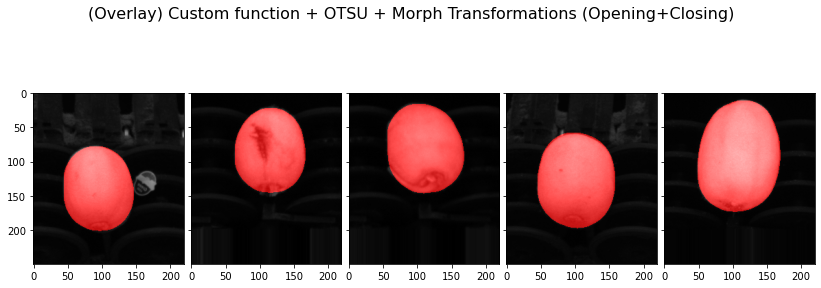

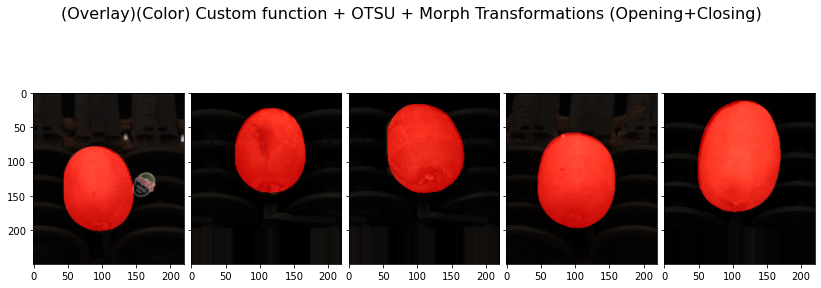

In [9]:
custom_otsu_masks = [customFunctionOtsuMorphKiwis(i, displacement) for i in imgs]

custom_otsu_overlay = [show_masking_effect(custom_otsu_masks[i], cv2.cvtColor(imgs[i],cv2.COLOR_GRAY2RGB)) for i in range(len(imgs))]

custom_otsu_overlay_color = [show_masking_effect(custom_otsu_masks[i], color_imgs[i]) for i in range(len(imgs))]

# plotting 
plot_images_row(custom_otsu_masks, title = "Custom function + OTSU + Morph Transformations (Opening+Closing)")
plot_images_row(custom_otsu_overlay, title = "(Overlay) Custom function + OTSU + Morph Transformations (Opening+Closing)")
plot_images_row(custom_otsu_overlay_color, title = "(Overlay)(Color) Custom function + OTSU + Morph Transformations (Opening+Closing)")

The obtained masks are sufficiently good to proceed with the next steps.

## Edge Detection

#### Canny's edge detection

In order to locate the defects, Canny edge detection algorithm is used. 

In order to complete the original idea of Canny, the image is gaussian-filtered before calling the OpenCv implementation ``cv2.Canny``. 

Furthermore, a final dilation pass (with a 3x3 cross) is done to fill possible holes in the borders.  

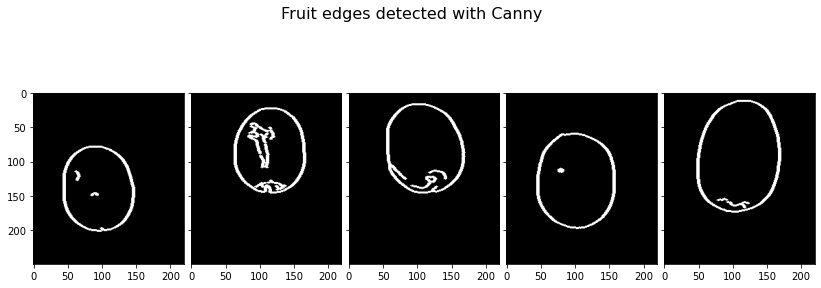

In [10]:
def cannyEdgeDetectionMorphKiwis(img, blurring_dim, canny_low, canny_high, show_output=False):
    '''
    This function proceeds:
    1. Filtering the image with a gaussian filter
    2. Applying OpenCv's Canny algorithm implementation (to find edges)
    3. Applying a final closing stage

    img: the image to which the whole process has to be applied
    blurring_dim: the kernel size for the gaussian filtering
    canny_low: the lower threshold for Canny's algorithm
    canny_high: the high threshold for Canny's algorithm

    returns: the edges of the original img
    '''
    im = img.copy()
    # Gaussian filtering
    im = cv2.GaussianBlur(im,(blurring_dim,blurring_dim),0)

    # Canny's OpenCv edge detection
    edges = cv2.Canny(im,canny_low,canny_high)
    
    # dilating by 3x3 cross
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,3))
    edges = cv2.dilate(edges, kernel_dilate)
    if show_output:
        plt.imshow(edges, cmap="gray")
        plt.title("Canny edge detection + Closing")
        plt.show()

    return edges


masked_images = [cv2.bitwise_and(imgs[i],np.array(custom_otsu_masks[i], dtype=np.uint8)) for i in range(len(custom_otsu_masks))]
color_masked_images = [cv2.bitwise_and(color_imgs[i],cv2.cvtColor(np.array(custom_otsu_masks[i], dtype=np.uint8), cv2.COLOR_GRAY2RGB)) for i in range(len(custom_otsu_masks))]


edges = [cannyEdgeDetectionMorphKiwis(i,blurring_dim=7,canny_low=30,canny_high=65) for i in masked_images]

plot_images_row(edges, title = "Fruit edges detected with Canny")


#### Main borders removal
If we want to operate directly on the edge defects and later fill em, we should first delete the overall contour of the fruit: this can be done performing an erosion.
Notice that if instead the deletion of the main border would have been based on some features like its (filled) area or similar, then some defects nearby the borders could have been later ignored by the location detection process.

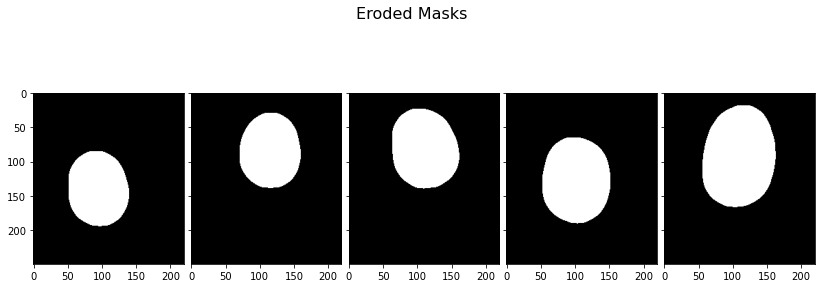

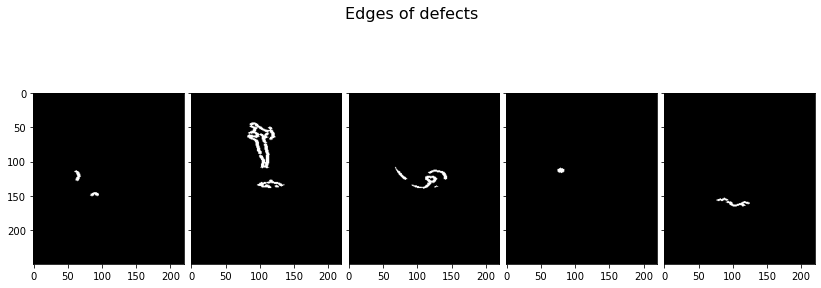

In [11]:
def erodeMask(mask, show_output=False):
    im = mask.copy()
    erosion_size=7
    erosion_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * erosion_size + 1, 2 * erosion_size + 1))
    erosion_dst = cv2.erode(im, erosion_element)

    if show_output:
        plt.imshow(mask,cmap="gray")
        plt.title("Eroded mask")
        plt.show()
    return erosion_dst

eroded_masks = [np.array(erodeMask(i),dtype=np.uint8) for i in custom_otsu_masks]
defects_edges = [cv2.bitwise_and(eroded_masks[i],edges[i]) for i in range(len(eroded_masks))]

plot_images_row(eroded_masks, title = "Eroded Masks")
plot_images_row(defects_edges, title = "Edges of defects")

## Defects localization & selection

The final selection of the defects is done using the following functions:


*   ```contourSelection```:

    1.   Detects contours using ```cv2.findContours``` with parameter ```cv2.RETR_EXTERNAL``` to avoid creating a hierarchy of inner/outer contours (and instead, merging them in a single contour)

    2.   Performs a selection based on the ```area```
*   ```boundingBoxSelection```: computes the defects bounding boxes 

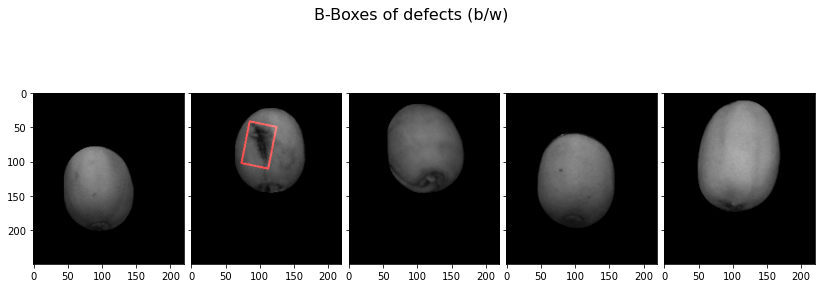

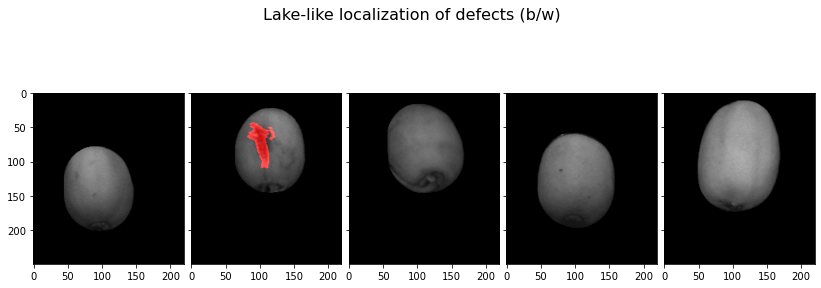

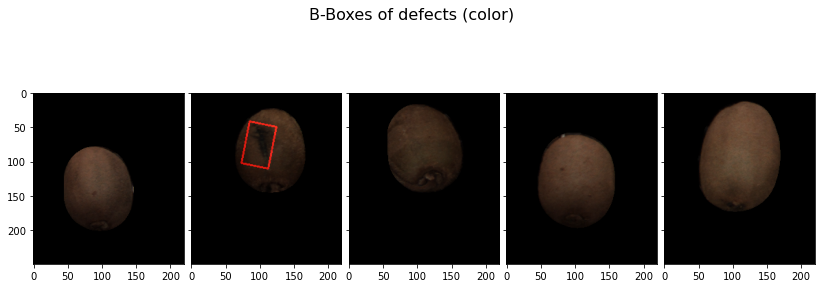

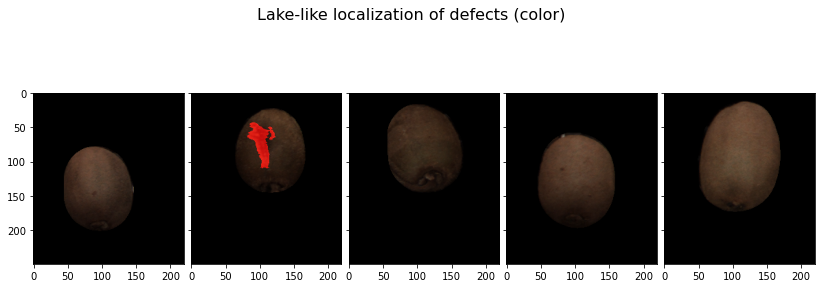

In [12]:
def contourSelectionKiwis(edge_image, verbose=False, show_output=False):
    # getting connected components following the 8-connected neighbors rule
    contour_list, hierarchy = cv2.findContours(edge_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    img = np.zeros(edge_image.shape)

    contour_list_clean = []

    for contour in contour_list:
        # computing the area of the contours (including all black pixels inside)
        area = cv2.contourArea(contour)

        # selection criterias for contoured blobs

        if area>800:
            contour_list_clean.append(contour)
            if verbose:
                print("selected: ",area)
        elif verbose:
            if area>0:
                print("not selected: ",area)
            else:
                print("not selected: ",area)

    if show_output:
        plt.imshow(img, cmap="gray")
        plt.title("Selected Contours")
        plt.show()

    return contour_list_clean

def boundingBoxSelectionKiwis(out_img_shape, contour_list, verbose=False, show_output=False):
    '''
    In this implementation, the contours in input are closed building a convex hull and
    they're filled with white.
    ____________________
    
    out_img_shape:  the dimensions of the mask in which contours have to be displayed
    contour_list:  a list containing the contour
    '''
    img = np.zeros(out_img_shape)
    resulting_rectangles = []
    resulting_contours = []
    for i in range(len(contour_list)):
        rect = cv2.minAreaRect(contour_list[i])
        box = cv2.boxPoints(rect)
        length = rect[1][0]
        width = rect[1][1]
        biggest_side = max(length,width)
        smallest_side = min(length,width)
        if verbose:
            print("big side/small side = ", biggest_side/smallest_side)

        box = np.int0(box)
        cv2.drawContours(img,[box],-1,(255,255,255),2)
        resulting_rectangles.append(rect)
        resulting_contours.append(contour_list[i])

        if show_output:
            plt.imshow(img, cmap="gray")
            plt.title("bounding boxes")
            plt.show()

    return img, resulting_rectangles, resulting_contours


selected_contours = [contourSelectionKiwis(i) for i in defects_edges]
selected_contour_bound_boxes = [np.array(boundingBoxSelectionKiwis(imgs[i].shape, selected_contours[i])[0], dtype=np.uint8) for i in range(len(selected_contours))]
selected_contour_lakes = [boundingBoxSelectionKiwis(imgs[i].shape, selected_contours[i])[2] for i in range(len(selected_contours))]

# Black & White images + masks overlay show
overlayed_defects_bound_box = [show_masking_effect(selected_contour_bound_boxes[i], cv2.cvtColor(masked_images[i],cv2.COLOR_GRAY2RGB)) for i in range(len(imgs))]

image_selected_contours = [np.array(cv2.drawContours(np.zeros(imgs[i].shape), selected_contour_lakes[i],-1, (255, 255, 255),thickness=cv2.FILLED),dtype=np.uint8) for i in range(len(selected_contours))]

overlayed_defects_lakes = [show_masking_effect(image_selected_contours[i], cv2.cvtColor(masked_images[i],cv2.COLOR_GRAY2RGB)) for i in range(len(imgs))]


plot_images_row(overlayed_defects_bound_box, title = "B-Boxes of defects (b/w)")
plot_images_row(overlayed_defects_lakes, title = "Lake-like localization of defects (b/w)")


# Color images + masks overlay show

overlayed_defects_lakes_color = [show_masking_effect(image_selected_contours[i], color_masked_images[i]) for i in range(len(imgs))]
overlayed_defects_bound_box_color = [show_masking_effect(selected_contour_bound_boxes[i], color_masked_images[i]) for i in range(len(imgs))]

plot_images_row(overlayed_defects_bound_box_color, title = "B-Boxes of defects (color)")
plot_images_row(overlayed_defects_lakes_color, title = "Lake-like localization of defects (color)")




The detection process successfully detects the target defects in the Kiwis, without false positives nor false negatives.

## Final defects detection

In this section, the whole described pipeline is applied to the original images. A time-based benchmark is made to give an estimate of the time needed to perform this quality check.

**N.B.:** Real industrial systems usually require low-level implementations (assembly,C++). The benchmark is done to give a kind of "average time / upper bound" with the (limited) number of samples we're given. In-production stage would require an eventual tuning and refinement of the described procedure.

![Task 2 pipeline](../other/pipeline_ex3.png "Task 2 pipeline")

In [21]:
import time
import platform,socket,re,uuid,json,psutil,logging

def detect_defects_kiwis(img, show_output=True):
    mask = img.copy()
    im = img.copy()
    overlayed_defects = None
    defect_lakes = None
    
    # Applying custom point operator function + otsu + morph operators
    mask = customFunctionOtsuMorphKiwis(mask, displacement=-19)
    
    # Canny Edge detection (Gauss filter + OpenCV implementation) + morph operators
    edges = cannyEdgeDetectionMorphKiwis(im,blurring_dim=7,canny_low=30,canny_high=65)
    
    # Eroding mask to avoid treating kiwis main contours
    eroded_mask = erodeMask(mask, show_output=False)

    # Found edges - apple main edge
    defects_edges = cv2.bitwise_and(np.array(eroded_mask,dtype=np.uint8),edges)

    # Contours selection (suppressing non interesting contours)
    selected_contours = contourSelectionKiwis(defects_edges, False)
    selected_contour_masks, rectangles, lakes = boundingBoxSelectionKiwis(im.shape, selected_contours, show_output=False)
    selected_contour_masks =  np.array(selected_contour_masks, dtype=np.uint8)


    if show_output:
        
        
        # Displaying as overlay the found bounding boxes on the original (masked) image
        overlayed_defects = show_masking_effect(selected_contour_masks, cv2.cvtColor(im,cv2.COLOR_GRAY2RGB), show_output=False)

    
        defect_lakes = np.array(cv2.drawContours(np.zeros(im.shape), selected_contours,-1, (255, 255, 255),thickness=cv2.FILLED),dtype=np.uint8)
    
        
        plt.imshow(defect_lakes, cmap="gray")
        plt.title("defects lake-like localization")
        plt.show()

        plt.imshow(overlayed_defects, cmap="gray")
        plt.title("defects bounding boxes overlay")
        plt.show()
    
    return overlayed_defects, rectangles, defect_lakes


def benchmark_kiwis_defects_detection(imgs,iterations):
    '''
    This function computes the average elapsed time for the detection process:
    
    imgs: images to which detection has to be applied
    iterations: number of times the detecton has to be performed on the whole set of imgs
    
    returns: the average time for each detection, in seconds
    '''
    start = time.time()
    for i in range(iterations):
      for j in imgs:
        detect_defects_kiwis(j,show_output=False)

    end = time.time()
    return (end-start)/(iterations*len(imgs))


def getSystemInfo():
    try:
        info={}
        info['platform']=platform.system()
        info['platform-release']=platform.release()
        info['platform-version']=platform.version()
        info['architecture']=platform.machine()
        info['processor']=platform.processor()
        info['ram']=str(round(psutil.virtual_memory().total / (1024.0 **3)))+" GB"
        return json.dumps(info)
    except Exception as e:
        logging.exception(e)

print("Average time for detection: ", benchmark_kiwis_defects_detection(imgs,1000))
print("Machine in use: ",json.loads(getSystemInfo()))

Average time for detection:  0.0379216682434082
Machine in use:  {'platform': 'Windows', 'platform-release': '10', 'platform-version': '10.0.19044', 'architecture': 'AMD64', 'processor': 'Intel64 Family 6 Model 142 Stepping 9, GenuineIntel', 'ram': '8 GB'}


The elapsed time is less than 0.04 seconds, a quite good result in terms of speed (of course, this has to be compared with the time needed by the mechanical stages involved in the transit of the fruit on the conveyor belt and of the actuators selecting the intact/damaged fruit path).

N.B.: Closing & Opening operations with big kernel takes a relevant amount of time - in a previous version I've tried using edge detection&selection techniques and it resulted in being faster, but a less elegant solution if compared to this one.